<a href="https://colab.research.google.com/github/PosgradoMNA/Proyecto_A01794099/blob/main/Avance3_Equipo12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

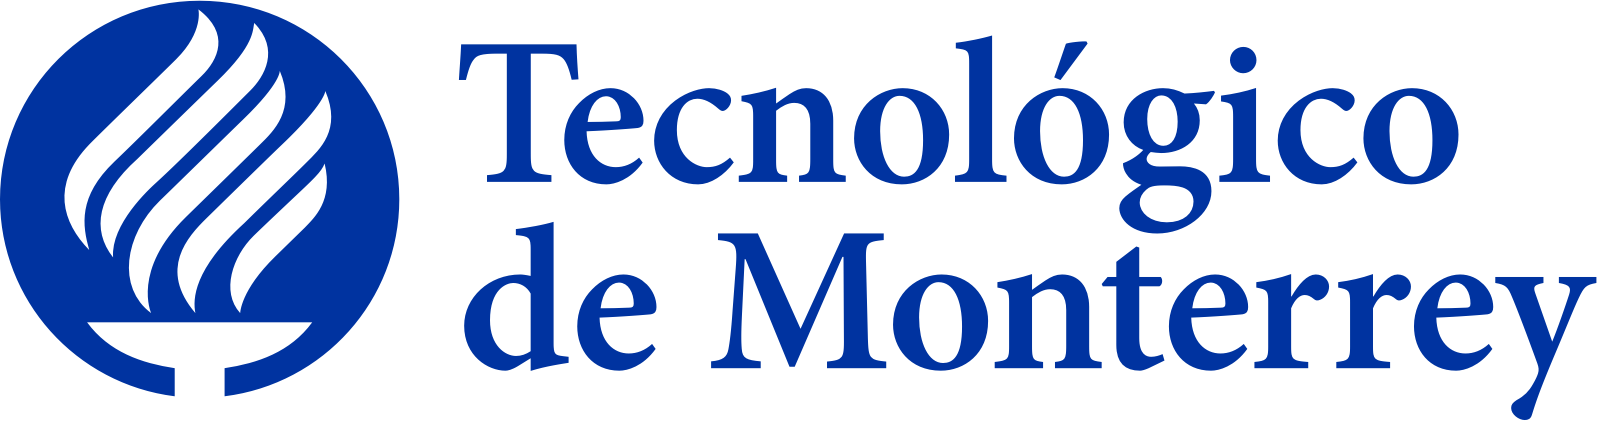

# Maestría en Inteligencia Artificial Aplicada
## Tecnológico de Monterrey
## TC5035.10 – Proyecto Integrador

### Avance 3 - Baseline: Reconocimiento robusto de comandos de voz en robots mediante paráfrasis y clasificación k-NN

**Profesores titulares: Dra. Grettel Barceló Alonso, Dr. Luis Eduardo Falcón Morales**

**Profesor asistente: Mtra. Verónica Sandra Guzmán de Valle**


**Equipo 12:**
*   Laura Irán González Ojeda - **A01794099**

En esta sección, cargaremos los datos, entrenaremos y procesaremos los vectores de comandos utilizando dos modelos de incrustación diferentes: SBERT (Sentence-BERT) y LaBSE (Language-agnostic BERT Sentence Embedding). El objetivo es calcular la distancia coseno entre estas incrustaciones y comparar el rendimiento de ambos modelos basándonos en las matrices de distancia.

**¿Qué algoritmo (individual, NO ensambles) se puede utilizar como baseline para predecir las variables objetivo?**

 Un algoritmo adecuado como baseline para este problema es k-Nearest Neighbors (k-NN), dado que el proyecto se basa en la clasificación de comandos verbales, y este modelo es efectivo para problemas de clasificación donde se busca similitud entre vectores, como en el caso de incrustaciones de comandos.

In [1]:
#Importación de Librerías
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ruta del archivo CSV en Google Drive
csv_file_path = '/content/drive/My Drive/Proyecto Integrador/Proyecto/data.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file_path)

# Mostrar las primeras filas del DataFrame
df.head()

,command,action
0,Shift the arm to the left,move_left
1,Position the arm to the left,move_left
2,Guide the arm to the left,move_left
3,Direct the arm towards the left,move_left
4,Adjust the arm to the left,move_left


#### Load models from HuggingFace

In [4]:
# Load SBERT model from Hugging Face
tokenizer_sbert = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model_sbert = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [7]:
# Load LaBSE model from Hugging Face
tokenizer_labse = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE')
model_labse = AutoModel.from_pretrained('sentence-transformers/LaBSE')

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

#### Function definition to obtaing embeddings and cosine distance calculation

In [5]:
def get_embeddings(texts, tokenizer, model):
    # Tokenize the texts and get embeddings
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)
'''
# Previous defined function to get
def classify_command(sentence, commands, command_embeddings, tokenizer, model):
    # Get the embedding for the input sentence
    sentence_embedding = get_embeddings([sentence], tokenizer, model)
    # Compute cosine similarity with all command embeddings
    similarities = cosine_similarity(sentence_embedding.cpu().numpy(), command_embeddings.cpu().numpy())
    # Find the index of the most similar command
    most_similar_idx = np.argmax(similarities)
    # Return the label of the most similar command
    return commands[most_similar_idx]
'''

'\n# Previous defined function to get \ndef classify_command(sentence, commands, command_embeddings, tokenizer, model):\n    # Get the embedding for the input sentence\n    sentence_embedding = get_embeddings([sentence], tokenizer, model)   \n    # Compute cosine similarity with all command embeddings\n    similarities = cosine_similarity(sentence_embedding.cpu().numpy(), command_embeddings.cpu().numpy())\n    # Find the index of the most similar command\n    most_similar_idx = np.argmax(similarities)   \n    # Return the label of the most similar command\n    return commands[most_similar_idx]\n'

In [6]:
def classify_command(sentence, command_list, command_embeddings, tokenizer, model, threshold):
    # Tokenizar y codificar la oración
    inputs = tokenizer(sentence, return_tensors='pt')
    sentence_embedding = model(**inputs).last_hidden_state.mean(dim=1)

    # Compute cosine similarity with all command embeddings
    similarity_matrix = cosine_similarity(sentence_embedding.cpu().detach().numpy(), command_embeddings.cpu().detach().numpy())
    distance_matrix = 1 - similarity_matrix

    # Find the index of the most similar distance
    min_distance_idx = np.argmin(distance_matrix)
    min_distance = distance_matrix[0][min_distance_idx]

    # Check if the minimum distance is within the threshold
    if min_distance <= threshold:
        predicted_command = command_list[min_distance_idx]
    else:
        predicted_command = None  # or some other value indicating no valid match

    return predicted_command, min_distance

In [12]:
# Compute embeddings for all commands using SBERT
command_embeddings_sbert = get_embeddings(df['command'].tolist(), tokenizer_sbert, model_sbert)

In [13]:
# Compute embeddings for all commands using LaBSE
command_embeddings_labse = get_embeddings(df['command'].tolist(), tokenizer_labse, model_labse)

#### Compute confusion matrix and distance calculation

**¿Se puede determinar la importancia de las características para el modelo generado?**

 Aunque los modelos de incrustación como SBERT y LaBSE no permiten identificar explícitamente la importancia de características individuales como un árbol de decisión o regresión lineal, sí es posible evaluar qué palabras o frases tienen más impacto en las predicciones analizando los pesos de las incrustaciones generadas. En este caso, el enfoque de distancia coseno mide la similitud entre comandos, ayudando a identificar las características semánticamente más relevantes para la clasificación.

In [10]:
# Define function to compute distance matrix
def compute_distance_matrix(command_embeddings):
    similarity_matrix = cosine_similarity(command_embeddings.cpu().numpy())
    distance_matrix = 1 - similarity_matrix  # Convert similarity to distance
    return distance_matrix

#Calcular la desviacion estandar
def compute_average_distance(distance_matrix):
    # Extract the upper triangular part of the matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    upper_triangular_values = distance_matrix[upper_triangular_indices]

    # Calculate the average distance
    average_distance = np.mean(upper_triangular_values)

    return average_distance

In [14]:
# Compute distance matrix for SBERT
distance_matrix_sbert = compute_distance_matrix(command_embeddings_sbert)
# Compute distance matrix for LaBSE
distance_matrix_labse = compute_distance_matrix(command_embeddings_labse)

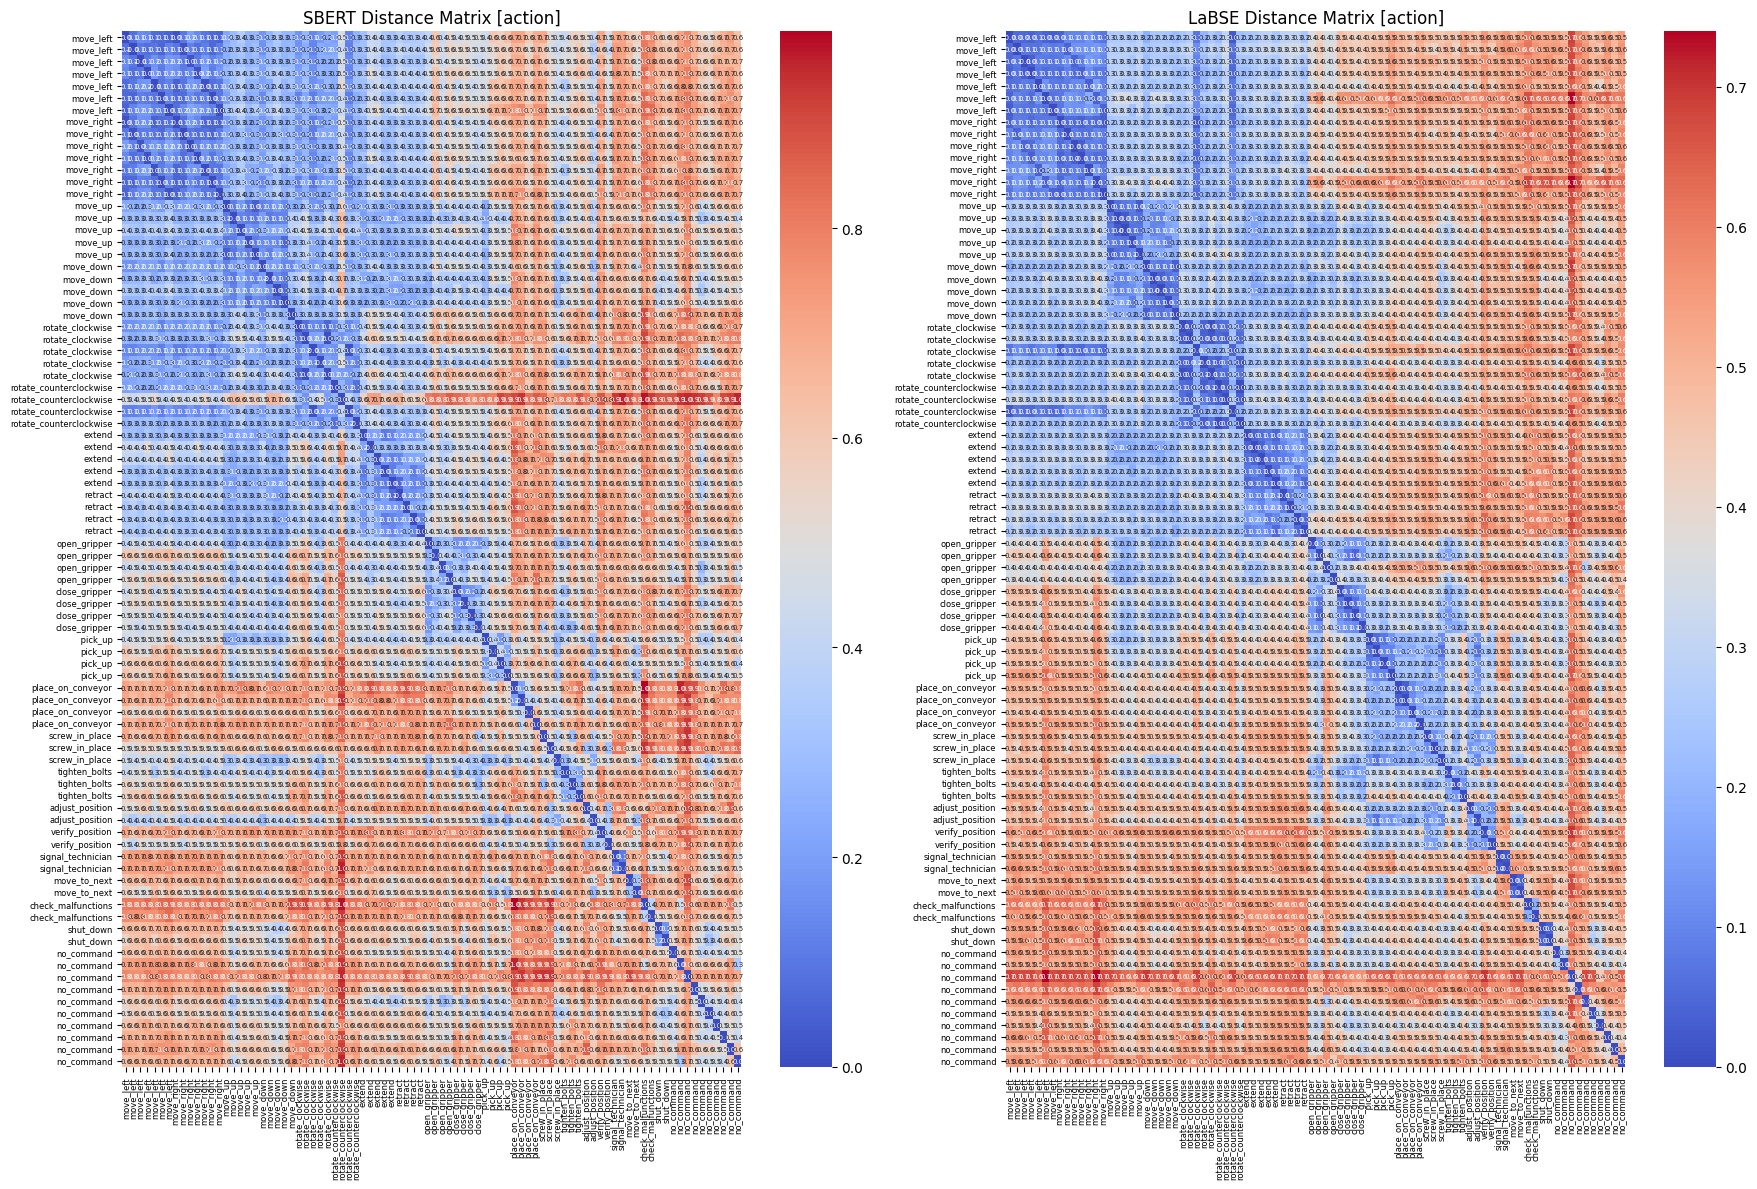

In [15]:
# Plot distance matrices
plt.figure(figsize=(18, 12))

plt.subplot(1, 2, 1)
sns.heatmap(distance_matrix_sbert, xticklabels=df['action'], yticklabels=df['action'], cmap='coolwarm', annot=True, fmt=".1f", annot_kws={"size": 5})
plt.title('SBERT Distance Matrix [action]')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(1, 2, 2)
sns.heatmap(distance_matrix_labse, xticklabels=df['action'], yticklabels=df['action'], cmap='coolwarm', annot=True, fmt=".1f", annot_kws={"size": 5})
plt.title('LaBSE Distance Matrix [action]')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()

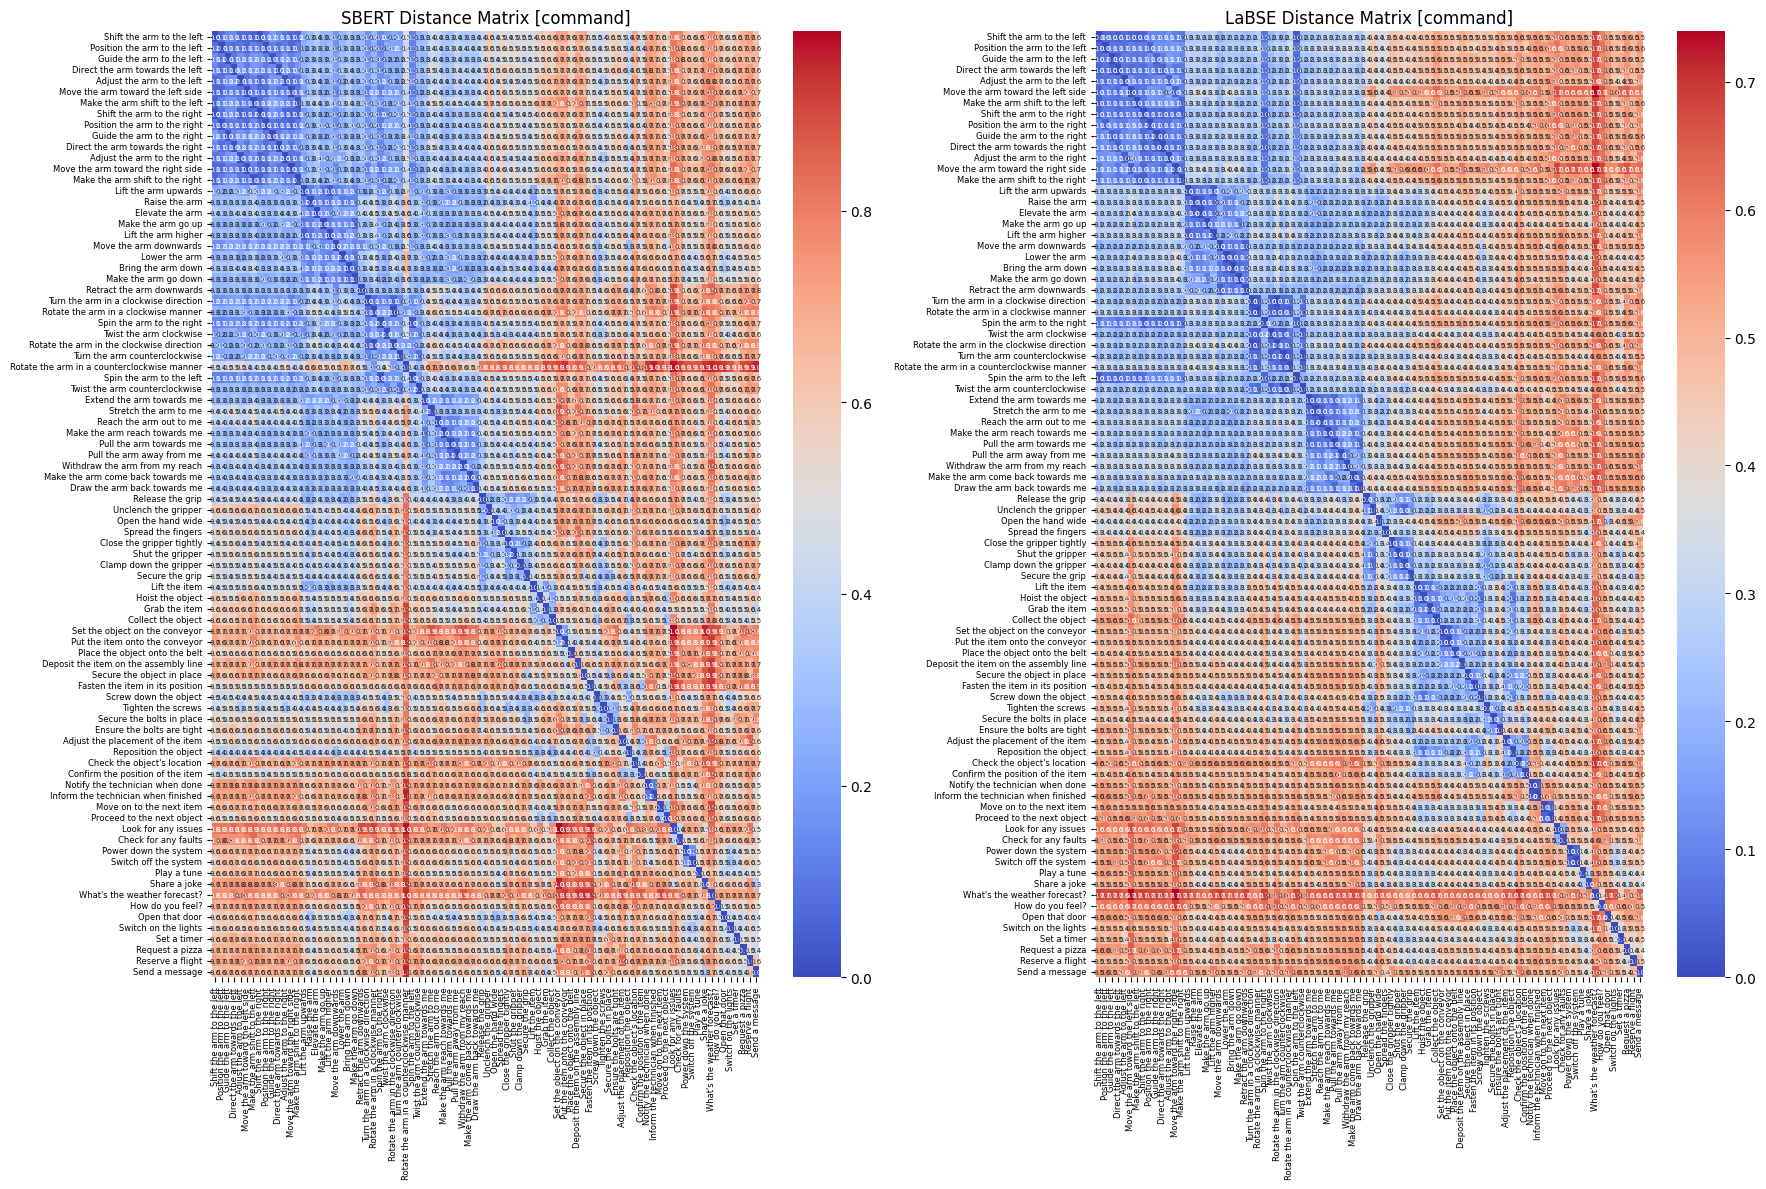

In [16]:
# Plot distance matrices
plt.figure(figsize=(18, 12))

plt.subplot(1, 2, 1)
sns.heatmap(distance_matrix_sbert, xticklabels=df['command'], yticklabels=df['command'], cmap='coolwarm', annot=True, fmt=".1f", annot_kws={"size": 5})
plt.title('SBERT Distance Matrix [command]')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(1, 2, 2)
sns.heatmap(distance_matrix_labse, xticklabels=df['command'], yticklabels=df['command'],cmap='coolwarm', annot=True, fmt=".1f", annot_kws={"size": 5})
plt.title('LaBSE Distance Matrix [command]')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()

#### Models Statistics - Threshold distance definition

In [17]:
# Define function to compute the average distances and standard deviation from a distance matrix
def compute_distance_statistics(distance_matrix, top_k):
    # Extract the upper triangular part of the matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    upper_triangular_values = distance_matrix[upper_triangular_indices]

    # Sort the distances
    sorted_distances = np.sort(upper_triangular_values)

    # Compute the average of the k smallest distances
    avg_closest_distances = np.mean(sorted_distances[:top_k])

    # Compute the average of the k largest distances
    avg_farthest_distances = np.mean(sorted_distances[-top_k:])

    # Compute the standard deviation of all distances
    std_dev_distances = np.std(sorted_distances)

    # Get the k smallest distances
    closest_distances = sorted_distances[:top_k]

    return avg_closest_distances, avg_farthest_distances, std_dev_distances, closest_distances

In [21]:
# Calculate matrix statistics SBERT
top_k=5
avg_closest_sbert, avg_farthest_sbert, std_dev_sbert, closest_distances_sbert = compute_distance_statistics(distance_matrix_sbert, top_k)
print(f"Average smallest distances SBERT: {avg_closest_sbert}")
print(f"Average largest distances SBERT: {avg_farthest_sbert}")
print(f"Standard desviation distances SBERT: {std_dev_sbert}")
print(f"Closest distances: {closest_distances_sbert}")

Average smallest distances SBERT: 0.012852895073592663
Average largest distances SBERT: 0.9680355191230774
Standard desviation distances SBERT: 0.1877143383026123
Closest distances: [0.00539988 0.01108682 0.01373124 0.01598859 0.01805794]


In [23]:
# Calculate matrix statistics LABSE
top_k=5
avg_closest_labse, avg_farthest_labse, std_dev_labse, closest_distances_labse = compute_distance_statistics(distance_matrix_labse, top_k)
print(f"Average smallest distances LABSE: {avg_closest_labse}")
print(f"Average largest distances LABSE: {avg_farthest_labse}")
print(f"Standard desviation distances LABSE: {std_dev_labse}")
print(f"Closest distances: {closest_distances_labse}")

Average smallest distances LABSE: 0.016154348850250244
Average largest distances LABSE: 0.7118614912033081
Standard desviation distances LABSE: 0.1407090127468109
Closest distances: [0.00564688 0.00811744 0.02139866 0.02274072 0.02286804]


In [28]:
# Define the threshold as the mean plus a fraction of the standard deviation
threshold_sbert = avg_closest_sbert + std_dev_sbert + 4
threshold_labse = avg_closest_labse + std_dev_labse + 3

print(f"Threshold for SBERT: {threshold_sbert}")
print(f"Threshold for LaBSE: {threshold_labse}")

Threshold for SBERT: 4.200567230582237
Threshold for LaBSE: 3.156863361597061


**¿El modelo está sub/sobreajustando los datos de entrenamiento?**

 A partir de la comparación de las matrices de distancia y el cálculo de la desviación estándar, SBERT muestra un mejor ajuste con menores distancias promedio y desviación estándar más baja. Esto sugiere que el modelo SBERT está mejor ajustado que LaBSE para este conjunto de datos y tarea, evitando tanto subajuste como sobreajuste en las predicciones de comandos.

#### Model Evaluation, Testing some sentences

**¿Cuál es la métrica adecuada para este problema de negocio?**

 La métrica más adecuada en este caso es la distancia coseno para medir la similitud entre las incrustaciones de los comandos verbales y las predicciones. También es importante utilizar una matriz de confusión para evaluar la precisión del modelo, ya que ayuda a determinar la efectividad de la clasificación de comandos verbales en la tarea de reconocimiento de comandos.

**¿Cuál debería ser el desempeño mínimo a obtener?**

 El desempeño mínimo aceptable debería estar basado en un umbral de precisión para la clasificación de comandos que permita una interacción fluida con el robot. Para este caso, se sugirió un umbral de distancia promedio de ≈0.18 para SBERT, lo que corresponde a un nivel de similitud alto, y un rendimiento general con una precisión de al menos 85-90% en la detección de comandos sería adecuado para garantizar la funcionalidad del sistema.

 A continuación, evaluaremos los modelos, para que ambos modelos clasifiquen adecuadamente un comando que no se encuentra en el dataset.

In [29]:
sentence = "Move your arm a little to the left"
# Test the classification function with SBERT
predicted_command_sbert, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_sbert, tokenizer_sbert, model_sbert, threshold_sbert)
print(f"The command for the sentence '{sentence}' using SBERT is: {predicted_command_sbert}")
print(f"The closest distance to the predicted command is: {closest_distance}")
# Test the classification function with LaBSE
predicted_command_labse, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_labse, tokenizer_labse, model_labse, threshold_labse)
print(f"The command for the sentence '{sentence}' using LaBSE is: {predicted_command_labse}")
print(f"The closest distance to the predicted command is: {closest_distance}")

The command for the sentence 'Move your arm a little to the left' using SBERT is: move_left
The closest distance to the predicted command is: 0.17799389362335205
The command for the sentence 'Move your arm a little to the left' using LaBSE is: move_left
The closest distance to the predicted command is: 0.11776876449584961


In [30]:
sentence = "Move your arm far away from me"
# Test the classification function with SBERT
predicted_command_sbert, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_sbert, tokenizer_sbert, model_sbert, threshold_sbert)
print(f"The command for the sentence '{sentence}' using SBERT is: {predicted_command_sbert}")
print(f"The closest distance to the predicted command is: {closest_distance}")
# Test the classification function with LaBSE
predicted_command_labse, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_labse, tokenizer_labse, model_labse, threshold_labse)
print(f"The command for the sentence '{sentence}' using LaBSE is: {predicted_command_labse}")
print(f"The closest distance to the predicted command is: {closest_distance}")

The command for the sentence 'Move your arm far away from me' using SBERT is: retract
The closest distance to the predicted command is: 0.2852555513381958
The command for the sentence 'Move your arm far away from me' using LaBSE is: retract
The closest distance to the predicted command is: 0.07062971591949463


In [31]:
sentence = "Move your arm a little to the right"
# Test the classification function with SBERT
predicted_command_sbert, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_sbert, tokenizer_sbert, model_sbert, threshold_sbert)
print(f"The command for the sentence '{sentence}' using SBERT is: {predicted_command_sbert}")
print(f"The closest distance to the predicted command is: {closest_distance}")
# Test the classification function with LaBSE
predicted_command_labse, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_labse, tokenizer_labse, model_labse, threshold_labse)
print(f"The command for the sentence '{sentence}' using LaBSE is: {predicted_command_labse}")
print(f"The closest distance to the predicted command is: {closest_distance}")

The command for the sentence 'Move your arm a little to the right' using SBERT is: move_right
The closest distance to the predicted command is: 0.18979805707931519
The command for the sentence 'Move your arm a little to the right' using LaBSE is: move_right
The closest distance to the predicted command is: 0.12008309364318848


In [32]:
sentence = "The weather is lovely today"
# Test the classification function with SBERT
predicted_command_sbert, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_sbert, tokenizer_sbert, model_sbert, threshold_sbert)
print(f"The command for the sentence '{sentence}' using SBERT is: {predicted_command_sbert}")
print(f"The closest distance to the predicted command is: {closest_distance}")
# Test the classification function with LaBSE
predicted_command_labse, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_labse, tokenizer_labse, model_labse, threshold_labse)
print(f"The command for the sentence '{sentence}' using LaBSE is: {predicted_command_labse}")
print(f"The closest distance to the predicted command is: {closest_distance}")

The command for the sentence 'The weather is lovely today' using SBERT is: no_command
The closest distance to the predicted command is: 0.5174072980880737
The command for the sentence 'The weather is lovely today' using LaBSE is: no_command
The closest distance to the predicted command is: 0.4703028202056885


In [33]:
sentence = "Who are The Beatles?"
# Test the classification function with SBERT
predicted_command_sbert, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_sbert, tokenizer_sbert, model_sbert, threshold_sbert)
print(f"The command for the sentence '{sentence}' using SBERT is: {predicted_command_sbert}")
print(f"The closest distance to the predicted command is: {closest_distance}")
# Test the classification function with LaBSE
predicted_command_labse, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_labse, tokenizer_labse, model_labse, threshold_labse)
print(f"The command for the sentence '{sentence}' using LaBSE is: {predicted_command_labse}")
print(f"The closest distance to the predicted command is: {closest_distance}")

The command for the sentence 'Who are The Beatles?' using SBERT is: no_command
The closest distance to the predicted command is: 0.8169854283332825
The command for the sentence 'Who are The Beatles?' using LaBSE is: tighten_bolts
The closest distance to the predicted command is: 0.40780818462371826


In [34]:
sentence = "Shut down"
# Test the classification function with SBERT
predicted_command_sbert, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_sbert, tokenizer_sbert, model_sbert, threshold_sbert)
print(f"The command for the sentence '{sentence}' using SBERT is: {predicted_command_sbert}")
print(f"The closest distance to the predicted command is: {closest_distance}")
# Test the classification function with LaBSE
predicted_command_labse, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_labse, tokenizer_labse, model_labse, threshold_labse)
print(f"The command for the sentence '{sentence}' using LaBSE is: {predicted_command_labse}")
print(f"The closest distance to the predicted command is: {closest_distance}")

The command for the sentence 'Shut down' using SBERT is: close_gripper
The closest distance to the predicted command is: 0.6530917882919312
The command for the sentence 'Shut down' using LaBSE is: close_gripper
The closest distance to the predicted command is: 0.1809523105621338


In [35]:
sentence = "Call the technician"
# Test the classification function with SBERT
predicted_command_sbert, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_sbert, tokenizer_sbert, model_sbert, threshold_sbert)
print(f"The command for the sentence '{sentence}' using SBERT is: {predicted_command_sbert}")
print(f"The closest distance to the predicted command is: {closest_distance}")
# Test the classification function with LaBSE
predicted_command_labse, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_labse, tokenizer_labse, model_labse, threshold_labse)
print(f"The command for the sentence '{sentence}' using LaBSE is: {predicted_command_labse}")
print(f"The closest distance to the predicted command is: {closest_distance}")

The command for the sentence 'Call the technician' using SBERT is: signal_technician
The closest distance to the predicted command is: 0.3632603883743286
The command for the sentence 'Call the technician' using LaBSE is: signal_technician
The closest distance to the predicted command is: 0.26285356283187866


In [36]:
sentence = "Call an engineer"
# Test the classification function with SBERT
predicted_command_sbert, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_sbert, tokenizer_sbert, model_sbert, threshold_sbert)
print(f"The command for the sentence '{sentence}' using SBERT is: {predicted_command_sbert}")
print(f"The closest distance to the predicted command is: {closest_distance}")
# Test the classification function with LaBSE
predicted_command_labse, closest_distance = classify_command(sentence, df['action'].tolist(), command_embeddings_labse, tokenizer_labse, model_labse, threshold_labse)
print(f"The command for the sentence '{sentence}' using LaBSE is: {predicted_command_labse}")
print(f"The closest distance to the predicted command is: {closest_distance}")

The command for the sentence 'Call an engineer' using SBERT is: signal_technician
The closest distance to the predicted command is: 0.6236284375190735
The command for the sentence 'Call an engineer' using LaBSE is: signal_technician
The closest distance to the predicted command is: 0.3168339729309082


#### Conclusiones
A partir de los resultados obtenidos al comparar el comportamiento de los modelos SBERT y LaBSE en la clasificación de comandos verbales, se concluye que aunque ambos modelos son capaces de clasificar correctamente varios comandos, SBERT ha mostrado un rendimiento superior en términos de consistencia y precisión, particularmente en la detección de comandos relevantes y en la identificación correcta de frases no relacionadas con comandos. Esto hace que SBERT sea una mejor opción para aplicaciones de detección de comandos verbales en robots.